# Sentiment Analysis

## Preparation


### Download data set and model configuration

In [1]:
!gdown --id 1TTB59QLNjWmlOYssuBClUigSIriibRCX --output trainning_data.csv
!gdown --id 1wmF255Z6bLssLdLWDz8bpiJgVpfbfLu1 --output model.h5
!gdown --id 1LXnz3ZA_OBee3NX5pIHhXQ9Cfmmjdh0A --output my_word2vec_model.model
!gdown --id 16GFdmIELoIXtnenB0tIlamX0x-putZuu --output encoder.pkl
!gdown --id 11HRLfRX3CEuF2Iuxke0GkAPpZgXHUWzC --output tokenizer.pkl


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TTB59QLNjWmlOYssuBClUigSIriibRCX
To: /content/trainning_data.csv
100% 239M/239M [00:04<00:00, 54.1MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wmF255Z6bLssLdLWDz8bpiJgVpfbfLu1
To: /content/model.h5
100% 350M/350M [00:02<00:00, 137MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?

### Import packages


In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [3]:
TRAIN = True
EVALUATE = True
# change TRAIN into True, you will retrain the model, else you will load the pretrained model

# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 20
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
EXE_NEGATIVE = "EXETREAMLY NEGATIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.15, 0.5)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


### Read dataset
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **text**: the text of the tweet (Lyx is cool)

In [4]:
dataset_filename = "trainning_data.csv"
print("Open file:", dataset_filename)
df = pd.read_csv(dataset_filename, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
print("Dataset size:", len(df))
df.head(5)

Open file: trainning_data.csv
Dataset size: 1600000


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Pre-Process dataset

### Remove link,user and special characters in text

In [5]:
# label
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]
df.target = df.target.apply(lambda x: decode_sentiment(x))


# text
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
df.text = df.text.apply(lambda x: preprocess(x))

# split train and test
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


##Process dataset and word embedding

### Word2Vec 
word imbedding

In [6]:
# if (TRAIN):
#   documents = [_text.split() for _text in df_train.text] 
  
#   w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,window=W2V_WINDOW,min_count=W2V_MIN_COUNT,workers=8)
#   w2v_model.build_vocab(documents)
#   words = w2v_model.wv.index_to_key
#   vocab_size = len(words)
#   print("Vocab size", vocab_size)

#   w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
#   w2v_model.save("my_word2vec_model.model")
  
# else:
w2v_model = gensim.models.word2vec.Word2Vec.load("my_word2vec_model.model")

# to see the representation of the word "love"
print(w2v_model.wv["love"].shape)
w2v_model.wv.vectors.shape

(300,)


(30369, 300)

### Tokenize Text


In [7]:
# # 创建一个tokenizer对象
# tokenizer2 = Tokenizer()

# # 拟合文本数据到tokenizer对象
# texts = ['this is an example sentence', 'this is another sentence']
# tokenizer2.fit_on_texts(texts)

# # 打印词汇表
# print(len(tokenizer2.word_index))

# # 将文本转换为整数序列
# sequences = tokenizer2.texts_to_sequences(texts)
# print(sequences)



In [8]:
tokenizer = Tokenizer()
if (True):
  with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
else:
  tokenizer.fit_on_texts(df_train.text)
  pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

if (TRAIN):
  x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
  x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Total words 290419


### Encode label

In [9]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [10]:
encoder = LabelEncoder()
if (True):
  with open('encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)
else:
  encoder.fit(df_train.target.tolist())
  pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

if (TRAIN):
  y_train = encoder.transform(df_train.target.tolist())
  y_test = encoder.transform(df_test.target.tolist())
  y_train = y_train.reshape(-1,1)
  y_test = y_test.reshape(-1,1)


  print("Therefore, our model will intake：\n")

  print("x_train", x_train.shape)
  print("y_train", y_train.shape)
  print()
  print("x_test", x_test.shape)
  print("y_test", y_test.shape)

Therefore, our model will intake：

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


## Model

### Embedding layer

In [11]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
 
print(embedding_matrix.shape)
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

(290419, 300)


### Build Model

In [12]:
if (TRAIN):
  model = Sequential()
  model.add(embedding_layer)
  model.add(Dropout(0.5))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1, activation='sigmoid'))

else:
  model = load_model('model.h5')

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [14]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [15]:
%%time
if (TRAIN):
  history = model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_split=0.1,
                      verbose=1,
                      callbacks=callbacks)
  model.save(KERAS_MODEL)

Epoch 1/20
1125/1125 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.7451

1125/1125 [==============================] - 499s 437ms/step - loss: 0.5124 - accuracy: 0.7451 - val_loss: 0.4658 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 2/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.7654

1125/1125 [==============================] - 498s 443ms/step - loss: 0.4818 - accuracy: 0.7654 - val_loss: 0.4593 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 3/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.7707

1125/1125 [==============================] - 491s 437ms/step - loss: 0.4743 - accuracy: 0.7707 - val_loss: 0.4550 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 4/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4700 - accuracy: 0.7731

1125/1125 [==============================] - 492s 438ms/step - loss: 0.4700 - accuracy: 0.7731 - val_loss: 0.4529 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 5/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4669 - accuracy: 0.7752

1125/1125 [==============================] - 490s 435ms/step - loss: 0.4669 - accuracy: 0.7752 - val_loss: 0.4509 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 6/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4652 - accuracy: 0.7763

1125/1125 [==============================] - 491s 437ms/step - loss: 0.4652 - accuracy: 0.7763 - val_loss: 0.4480 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 7/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4635 - accuracy: 0.7774

1125/1125 [==============================] - 492s 437ms/step - loss: 0.4635 - accuracy: 0.7774 - val_loss: 0.4468 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 8/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4621 - accuracy: 0.7781

1125/1125 [==============================] - 492s 438ms/step - loss: 0.4621 - accuracy: 0.7781 - val_loss: 0.4470 - val_accuracy: 0.7903 - lr: 0.0010
Epoch 9/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.7788

1125/1125 [==============================] - 493s 438ms/step - loss: 0.4609 - accuracy: 0.7788 - val_loss: 0.4468 - val_accuracy: 0.7901 - lr: 0.0010
Epoch 10/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.7796

1125/1125 [==============================] - 493s 438ms/step - loss: 0.4600 - accuracy: 0.7796 - val_loss: 0.4447 - val_accuracy: 0.7909 - lr: 0.0010
Epoch 11/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4598 - accuracy: 0.7795

1125/1125 [==============================] - 492s 437ms/step - loss: 0.4598 - accuracy: 0.7795 - val_loss: 0.4451 - val_accuracy: 0.7914 - lr: 0.0010
Epoch 12/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4592 - accuracy: 0.7797

1125/1125 [==============================] - 488s 434ms/step - loss: 0.4592 - accuracy: 0.7797 - val_loss: 0.4445 - val_accuracy: 0.7909 - lr: 0.0010
Epoch 13/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4587 - accuracy: 0.7800

1125/1125 [==============================] - 486s 432ms/step - loss: 0.4587 - accuracy: 0.7800 - val_loss: 0.4443 - val_accuracy: 0.7916 - lr: 0.0010
Epoch 14/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4582 - accuracy: 0.7804

1125/1125 [==============================] - 485s 431ms/step - loss: 0.4582 - accuracy: 0.7804 - val_loss: 0.4445 - val_accuracy: 0.7912 - lr: 0.0010
Epoch 15/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.7808

1125/1125 [==============================] - 485s 431ms/step - loss: 0.4577 - accuracy: 0.7808 - val_loss: 0.4448 - val_accuracy: 0.7916 - lr: 0.0010
Epoch 16/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4573 - accuracy: 0.7811

1125/1125 [==============================] - 485s 431ms/step - loss: 0.4573 - accuracy: 0.7811 - val_loss: 0.4447 - val_accuracy: 0.7913 - lr: 0.0010
Epoch 17/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.7813

1125/1125 [==============================] - 486s 432ms/step - loss: 0.4568 - accuracy: 0.7813 - val_loss: 0.4437 - val_accuracy: 0.7912 - lr: 0.0010
Epoch 18/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.7810

1125/1125 [==============================] - 488s 433ms/step - loss: 0.4568 - accuracy: 0.7810 - val_loss: 0.4433 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 19/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.7813

1125/1125 [==============================] - 490s 436ms/step - loss: 0.4567 - accuracy: 0.7813 - val_loss: 0.4427 - val_accuracy: 0.7924 - lr: 0.0010
Epoch 20/20
1125/1125 [==============================] - ETA: 0s - loss: 0.4563 - accuracy: 0.7816

1125/1125 [==============================] - 486s 432ms/step - loss: 0.4563 - accuracy: 0.7816 - val_loss: 0.4423 - val_accuracy: 0.7927 - lr: 0.0010
CPU times: user 3h 26min 25s, sys: 13min 5s, total: 3h 39min 30s
Wall time: 2h 43min 25s


### Evaluate

In [16]:
if (EVALUATE):
  score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
  print()
  print("ACCURACY:",score[1])
  print("LOSS:",score[0])

313/313 [==============================] - 33s 104ms/step - loss: 0.4409 - accuracy: 0.7934

ACCURACY: 0.793403148651123
LOSS: 0.4409252405166626


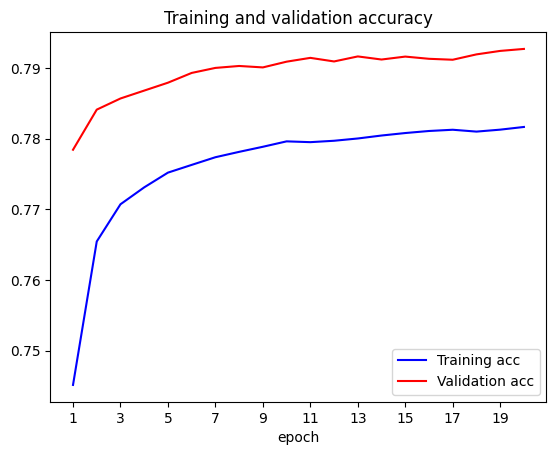

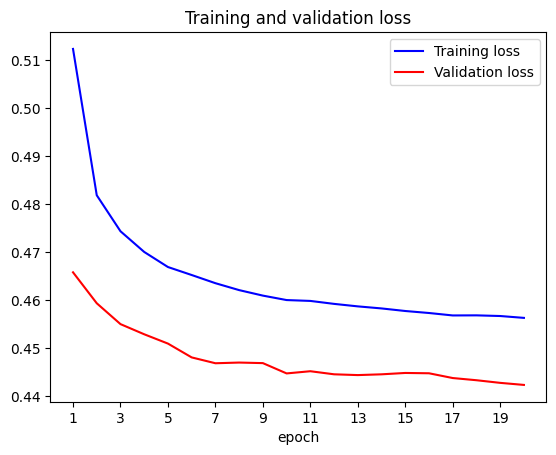

In [17]:
if (TRAIN):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs = range(1,len(acc)+1)
  
  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xticks(range(1, 21, 2))
  plt.xlabel('epoch')
  plt.legend()
  
  plt.figure()
  
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xticks(range(1, 21, 2))
  plt.xlabel('epoch')
  plt.legend()
  
  plt.show()

## Predict

In [18]:
def decode_sentiment(score):
  label = NEGATIVE
  if score <= SENTIMENT_THRESHOLDS[0]:
      label = EXE_NEGATIVE
  elif score >= SENTIMENT_THRESHOLDS[1]:
      label = NEUTRAL

  return label
  

def predict(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score)}  

### Several tests

In [19]:
predict("This braised pork clearly has a sour taste, are they trying to deceive people? I took one bite and almost vomited. During the epidemic period, shouldn't we pay more attention to food safety? It is reasonable to suspect that this is leftover food that has gone bad!")

1/1 [==============================] - 0s 323ms/step


{'label': 'EXETREAMLY NEGATIVE', 'score': 0.12560996413230896}

In [20]:
predict("It's really too hot!!!! Can you lower the temperature a bit?")

1/1 [==============================] - 0s 99ms/step


{'label': 'EXETREAMLY NEGATIVE', 'score': 0.1005818173289299}

In [21]:
predict("I found foreign objects (possibly a steel wire ball) in my rice, and when I finished class at 12:20, there were not many dishes left in the small bowl area, especially no green leafy vegetables. The soup was also very oily.")

1/1 [==============================] - 0s 97ms/step


{'label': 'NEGATIVE', 'score': 0.21480728685855865}

In [22]:
predict("Hair found in the dish.")

1/1 [==============================] - 0s 93ms/step


{'label': 'NEUTRAL', 'score': 0.6095613837242126}

In [23]:
predict("This is a complaint about the second canteen at school, which I will focus on, since the other canteens have bigger issues. Today, there was no one serving food again. I couldn't bear it any longer. Don't tell me it's because of the time I go there. I always go after 11 o'clock during the operating hours. Shouldn't the canteen ensure that there are people serving every minute during operating hours? Is the fair scale just for show? I urge the school management to go there at random times and see if there are people serving. Would they only catch someone there 3 out of 10 times? If there's no one there, who should I talk to about the missing weight on the scale? You may wonder why I bother going there. If I don't go, does it matter if there's no one there? You just eat your food, why do you care about the weight? Yes, why? Why is there less food on the scale than there should be? First, let's start with the small dish window. I sincerely admire the person who came up with the name. It perfectly reflects the characteristic of this canteen: small. The utensils are small, and the people serving are extremely accurate in controlling the amount of food. Each time, they cover only the area that is concave in the middle, without exceeding a single bit. Especially the aunties on the day shift, I really admire them. I won't talk about how little they serve; only those who eat there know. I know that all the cleaners only eat at that window. I understand that, as we are all in the same situation of being unable to afford more than single-digit meals. I have personally experienced that the grandpa in front of me asked the cashier how much each dish costs when he saw the total amount. Why did he ask? Obviously, because the mark-up is so heavy! Let me not talk about how much it costs to eat at other universities; even in comparison to the quality of the food and the amount we get here, what is going on? Just ask any of the cleaners, is there anyone who doesn't feel cheated? Second, there is the so-called Guangdong-style bar")

1/1 [==============================] - 0s 100ms/step


{'label': 'NEGATIVE', 'score': 0.2501275837421417}

In [24]:
predict("fuck!! This is the worst")

1/1 [==============================] - 0s 94ms/step


{'label': 'EXETREAMLY NEGATIVE', 'score': 0.03156078979372978}

### Predict Our Complaint


In [25]:
!gdown --id 1M8JeTEQRl8b44xnY99C8-CpxmYH0TUoO --output complaint.csv


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1M8JeTEQRl8b44xnY99C8-CpxmYH0TUoO
To: /content/complaint.csv
100% 49.4k/49.4k [00:00<00:00, 136MB/s]


In [26]:
import csv

# 打开输入和输出文件
with open('complaint.csv', 'r') as input_file, open('output.csv', 'w', newline='') as output_file:
    # 使用csv读取器和写入器
    reader = csv.reader(input_file)
    writer = csv.writer(output_file)

    # 遍历每一行
    for row in reader:
        # 删除评论中的所有引号
        if (row):
          comment = row[2].replace('"', '')
          # 提交评论给评分机进行评分
          result = predict(comment)

          # 将评分和标签添加到行的末尾
          row.insert(0, result["label"])
          row.insert(0, result["score"])
          # 写入新行到输出文件
          writer.writerow(row)


1/1 [==============================] - 0s 98ms/step
